In [1]:
# Package Imports
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import thefuzz
import thefuzz.fuzz as fuzz
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

In [2]:
# Variable names are the original user's name/initials for crediting

# Personal workout data
# No missing values
av_data = pd.read_csv('data/av-bolt.csv').drop_duplicates()

# 721 Weight Training Workouts Dataset: https://www.kaggle.com/datasets/joep89/weightlifting
# No missing values
joe89_data = pd.read_csv('data/weightlifting_721_workouts.csv').drop_duplicates()

# Hevy App Workout Dataset: From Dumbbells to Data: https://www.kaggle.com/datasets/tejaswinimukesh/hevy-app-workout-dataset-from-dumbbells-to-data
# Missing values
ts_data = pd.read_csv('data/Hevy_workouts_log_100_weeks.csv').drop_duplicates()

# All time Hevy Workouts 23/05/2025: https://www.kaggle.com/datasets/varlopecar/all-time-hevy-workouts-23052025
# Missing values
cv_data = pd.read_csv('data/Hevy_Workouts.csv').drop_duplicates()

# Weight Training: https://www.kaggle.com/datasets/jollychappies/weight-training/data 
# No missing values
dsm_data = pd.read_csv('data/strong.csv').drop_duplicates()

## Data Cleaning & EDA

In [3]:
MAX_DIST = 0.05

# All: Convert Date to easily workable Timestamp objects, titles column names
av_data['Date'] = pd.to_datetime(av_data['Date'])
av_data.columns = av_data.columns.str.title()

joe89_data['Date'] = pd.to_datetime(joe89_data['Date'])
joe89_data.columns = joe89_data.columns.str.title()

dsm_data['Date'] = pd.to_datetime(dsm_data['Date'])
dsm_data.columns = dsm_data.columns.str.title()


# AV: This sets warmup and drop sets to the the 0th set, could change this later for adding had_warmup as a feature
av_data['Set'] = (av_data['Set'].replace(['W'], 0)) 

# AV: Converts all 'D' sets (Dropset) to normal sets by having it be one more than the last one
sets_numeric = pd.to_numeric(av_data['Set'], errors='coerce')
sets_ffill = sets_numeric.ffill()
av_data.loc[av_data['Set'] == 'D', 'Set'] = sets_ffill[av_data['Set'] == 'D'] + 1
av_data['Set'] = av_data['Set'].astype('int64')   


# J89: combines extremely similar exercise names and cleans names in general
# for name in joe89_data['Exercise Name'].unique():
#     similar_mask = joe89_data['Exercise Name'].apply(lambda x: fuzz.ratio(name, x) >= (1-MAX_DIST)*100)
#     similar_names = joe89_data['Exercise Name'][similar_mask]

joe89_data['Exercise Name'] = joe89_data['Exercise Name'].str.title().str.replace(r'\.', "", regex=True)

# All: Calculate workout volume by set
av_data['Volume'] = av_data['Reps']*av_data['Weight']
joe89_data['Volume'] = joe89_data['Reps']*joe89_data['Weight']
dsm_data['Volume'] = dsm_data['Reps']*dsm_data['Weight']

# All: Drop unnecessary columns
# DSM: Choosing to leave out RPE (Rate of Perceived Exertion) for now, come back later as it could be a very useful feature
av_data.drop(columns=['Distance','Duration', 'Level', 'Notes', 'Workout Name'], inplace=True)
joe89_data.drop(columns=['Distance','Seconds', 'Workout Notes', 'Notes', 'Workout Name'], inplace=True)
dsm_data.drop(columns=['Distance','Seconds', 'Workout Notes', 'Notes', 'Workout Name', 'Duration', 'Rpe'], inplace=True)

# All: Adding User IDs
joe89_data['User ID'] = 0
joe89_data = joe89_data.set_index('User ID').reset_index()

dsm_data['User ID'] = 1
dsm_data = dsm_data.set_index('User ID').reset_index()

master_df = pd.concat([joe89_data, dsm_data], ignore_index=True)
master_df = master_df[master_df['Exercise Name'] != 'Stairmaster']
master_df = master_df[master_df['Exercise Name'] != 'Rope Never Ending ']
master_df = master_df[master_df['Exercise Name'] != "Cycling (Indoor)"]


# Find and fix incorrect squat weight of 2956 to 295
squat_mask = (master_df['Exercise Name'] == 'Squat (Barbell)') & (master_df['Weight'] > 2900)
master_df.loc[squat_mask, 'Weight'] = 295
# Recalculate volume for the corrected row
master_df.loc[squat_mask, 'Volume'] = master_df.loc[squat_mask, 'Weight'] * master_df.loc[squat_mask, 'Reps']

# Remove duplicate rows from master_df
master_df = master_df.drop_duplicates()
master_df


,User ID,Date,Exercise Name,Set Order,Weight,Reps,Volume
0,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),1,135.00,8,1080.00
1,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),2,135.00,8,1080.00
2,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),3,135.00,5,675.00
3,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),4,185.00,7,1295.00
4,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),5,230.00,8,1840.00
...,...,...,...,...,...,...,...
12861,1,2024-02-02 17:37:32,Lateral Raise (Dumbbell),4,18.00,3,54.00
12862,1,2024-02-02 17:37:32,Seated Row (Cable),1,41.25,12,495.00
12863,1,2024-02-02 17:37:32,Seated Row (Cable),2,41.25,8,330.00
12864,1,2024-02-02 17:37:32,Seated Row (Cable),3,41.25,5,206.25


In [4]:
master_map = {
    "Lateral Raise": "Lateral Raise (Dumbbell)",
    "Lateral Raise (Dumbbells)": "Lateral Raise (Dumbbell)",
    "Incline Bench Press": "Incline Bench Press (Barbell)",
    "Bicep Curl (Barbell )": "Bicep Curl (Barbell)",
    "sumo deadlift": "Sumo Deadlift",
    "Squat": 'Squat (Barbell)',
    "Good Morning": "Good Morning (Barbell)",
    "Lat Pulldown ": 'Lat Pulldown (Cable)',
    "Hammer Curl (Dumbbell )": 'Hammer Curl (Dumbbell)',
    "Hammer Curl": 'Hammer Curl (Dumbbell)',
    "Leg Press (Hinge )": "Leg Press (Hinge)",
    "Seated Shoulder  Press (Barbell)": "Seated Shoulder Press (Barbell)",
    "Tricep Extension": "Triceps Extension (Cable)",
    "Tricep Pushdown": "Triceps Pushdown (Cable - Straight Bar)",
    "Deadlift": "Deadlift (Barbell)",
    "Shrug (Dumbell)": "Shrugs (Dumbbell)",
    "Overhead Press (Dumbbell)": "Shoulder Press (Standing)",
    'Low Incline Dumbbell Bench': 'Incline Bench Press (Dumbbell)',
    "Lying Skullcrusher": 'Skullcrusher (Barbell)',
    "Curl Dumbbell": "Bicep Curl (Dumbbell)",
    "Lat Pulldown Closegrip": "Lat Pulldown (Cable)",
    "Lat Pulldown - Underhand Close Grip": "Lat Pulldown (Cable)",
    "Lat Pulldown - Wide Grip (Cable)": "Lat Pulldown (Cable)",
    "Incline Press (Dumbbell)": "Incline Bench Press (Dumbbell)",
    "Seated Row": "Seated Row (Cable)",
    "Leg Curl": "Seated Leg Curl (Machine)",
    "Leg Press": "Seated Leg Press (Machine)",
    "Seated Overhead Press (Dumbbell)": "Seated Shoulder Press (Dumbbell)",
}

master_df['Exercise Name'] = master_df['Exercise Name'].replace(master_map)
master_df = master_df.drop_duplicates()
master_df

,User ID,Date,Exercise Name,Set Order,Weight,Reps,Volume
0,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),1,135.00,8,1080.00
1,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),2,135.00,8,1080.00
2,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),3,135.00,5,675.00
3,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),4,185.00,7,1295.00
4,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),5,230.00,8,1840.00
...,...,...,...,...,...,...,...
12861,1,2024-02-02 17:37:32,Lateral Raise (Dumbbell),4,18.00,3,54.00
12862,1,2024-02-02 17:37:32,Seated Row (Cable),1,41.25,12,495.00
12863,1,2024-02-02 17:37:32,Seated Row (Cable),2,41.25,8,330.00
12864,1,2024-02-02 17:37:32,Seated Row (Cable),3,41.25,5,206.25


In [ ]:
# gets the total movement's volume for that day's workout
av_volume = av_data.groupby(['Date','Exercise Name'])['Volume'].sum().reset_index()
av_volume['Exercise Name'].value_counts()

joe89_volume = joe89_data.groupby(['Date','Exercise Name'])['Volume'].sum().reset_index()
joe89_data['Exercise Name'].value_counts()

dsm_volume = dsm_data.groupby(['Date','Exercise Name'])['Volume'].sum().reset_index()
dsm_data['Exercise Name'].value_counts()


In [5]:
# Plot the top 10 exercises by count
av_top_exercises = (
    av_volume['Exercise Name']
    .value_counts()
    .head(10)
    .index
)
av_t10 = av_volume[av_volume['Exercise Name'].isin(av_top_exercises)]


fig = px.line(av_t10, x='Date', y='Volume', color='Exercise Name')
fig.show()

In [7]:
joe89_top_exercises = (
    joe89_data['Exercise Name']
    .value_counts()
    .head(10)
    .index
)
joe89_t10 = joe89_volume[joe89_volume['Exercise Name'].isin(joe89_top_exercises)].copy()

# standardize the data
joe89_t10['Volume_zscore'] = joe89_t10.groupby('Exercise Name')['Volume'].transform(lambda x: (x - x.mean()) / x.std())



# fig = px.line(joe89_t10, x='Date', y='Volume', color='Exercise Name')
# fig.show()

fig = px.line(joe89_t10, x='Date', y='Volume_zscore', color='Exercise Name')
fig.show()

joe89_t10_weekly = joe89_t10.groupby(['Exercise Name', pd.Grouper(key='Date', freq='M')])['Volume_zscore'].sum().reset_index()

fig = px.line(joe89_t10_weekly, x='Date', y='Volume_zscore', color='Exercise Name', 
              title='Monthly Volume by Exercise (Top 10)')
fig.update_layout(xaxis_title='Date', yaxis_title='Weekly Volume')
fig.show()

/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_60547/4063381507.py:20: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [8]:
dsm_top_exercises = (
    dsm_data['Exercise Name']
    .value_counts()
    .head(10)
    .index
)
dsm_t10 = dsm_volume[dsm_volume['Exercise Name'].isin(dsm_top_exercises)]


fig = px.line(dsm_t10, x='Date', y='Volume', color='Exercise Name')
fig.show()

In [27]:
master_df_num_workouts = (master_df
                .groupby(['User ID', pd.Grouper(key='Date', freq='ME')])['Date'].nunique()
                .to_frame(name='Workouts')
                .reset_index())

fig = px.line(master_df_num_workouts, x='Date', y='Workouts', color='User ID', 
              title='Workouts Per Month')
fig.update_layout(xaxis_title='Date', yaxis_title='Workouts')
fig.show()


In [6]:
# Find the first workout date for each user
first_dates = master_df.groupby('User ID')['Date'].min().rename('First Date')

# Merge this info back into the main dataframe
master_df = master_df.merge(first_dates, on='User ID')

# Create a new column for 2-week periods since first workout
master_df['Two Week Period'] = ((master_df['Date'] - master_df['First Date']).dt.days // 14)

users = master_df['User ID'].unique()
exercise_sets = [set(master_df[master_df['User ID'] == user]['Exercise Name']) for user in users]
common_exercises = set.intersection(*exercise_sets)

# 2. From these, select the top 5 by total count
common_exercises_df = master_df[master_df['Exercise Name'].isin(common_exercises)]
top_common_exercises = (common_exercises_df
                        .groupby('Exercise Name')
                        .size()
                        .sort_values(ascending=False)
                        .index[:5]
                        .tolist())

# 3. Filter for these exercises
top_exercises_df = master_df[master_df['Exercise Name'].isin(top_common_exercises)]

# Calculate mean volume for each 2-week period
top_exercises_df = (top_exercises_df
                   .groupby(['User ID', 'Exercise Name', 'Two Week Period'])
                   ['Volume']
                   .mean()
                   .reset_index())

# Plot using the normalized x-axis and standardized volume
fig = px.line(
    top_exercises_df,
    x='Two Week Period',
    y='Volume', 
    color='Exercise Name',
    facet_row='User ID',
    title='Volume Over Time by Common Exercises and User'
)
fig.update_layout(xaxis_title='Two Week Periods Since First Workout')
fig.for_each_yaxis(lambda yaxis: yaxis.update(matches=None))
fig.show()

In [7]:
# Sanity checking the data for duplicates
master_df[(master_df['Exercise Name'] == 'Incline Bench Press (Barbell)') & (master_df['Date'].dt.year == 2016) & (master_df['Date'].dt.month == 6)]

,User ID,Date,Exercise Name,Set Order,Weight,Reps,Volume,First Date,Two Week Period
1677,0,2016-06-06 20:41:36,Incline Bench Press (Barbell),1,135.0,8,1080.0,2015-10-23 17:06:37,16
1678,0,2016-06-06 20:41:36,Incline Bench Press (Barbell),2,135.0,8,1080.0,2015-10-23 17:06:37,16
1679,0,2016-06-06 20:41:36,Incline Bench Press (Barbell),3,185.0,6,1110.0,2015-10-23 17:06:37,16
1680,0,2016-06-06 20:41:36,Incline Bench Press (Barbell),4,225.0,8,1800.0,2015-10-23 17:06:37,16
1681,0,2016-06-06 20:41:36,Incline Bench Press (Barbell),5,225.0,8,1800.0,2015-10-23 17:06:37,16
1682,0,2016-06-06 20:41:36,Incline Bench Press (Barbell),6,225.0,8,1800.0,2015-10-23 17:06:37,16
1829,0,2016-06-25 16:55:10,Incline Bench Press (Barbell),1,135.0,8,1080.0,2015-10-23 17:06:37,17
1830,0,2016-06-25 16:55:10,Incline Bench Press (Barbell),2,185.0,8,1480.0,2015-10-23 17:06:37,17
1831,0,2016-06-25 16:55:10,Incline Bench Press (Barbell),3,225.0,8,1800.0,2015-10-23 17:06:37,17
1832,0,2016-06-25 16:55:10,Incline Bench Press (Barbell),4,225.0,8,1800.0,2015-10-23 17:06:37,17


In [21]:
# Calculate the total number of workouts per exercise for each user
workout_counts = (master_df
                 .groupby(['User ID', 'Exercise Name'])
                 .size()
                 .reset_index(name='Count'))

# Create subplots - one pie chart per user
fig = make_subplots(rows=len(users), cols=1, 
                    subplot_titles=[f'User {user} Exercise Distribution' for user in users],
                    specs=[[{"type": "pie"}] for _ in users])

for idx, user in enumerate(users, 1):
    user_data = workout_counts[workout_counts['User ID'] == user]
    
    # Calculate percentages and group exercises < 1% into "Other"
    total = user_data['Count'].sum()
    user_data['Percentage'] = user_data['Count'] / total * 100
    
    # Separate into main exercises and "Other"
    main_exercises = user_data[user_data['Percentage'] >= 1.5]
    other_exercises = user_data[user_data['Percentage'] < 1.5]
    
    # If there are exercises < 1%, combine them
    if not other_exercises.empty:
        other_sum = other_exercises['Count'].sum()
        other_row = pd.DataFrame({
            'User ID': [user],
            'Exercise Name': ['Other'],
            'Count': [other_sum],
            'Percentage': [other_exercises['Percentage'].sum()]
        })
        main_exercises = pd.concat([main_exercises, other_row], ignore_index=True)
    
    fig.add_trace(
        go.Pie(labels=main_exercises['Exercise Name'],
               values=main_exercises['Count'],
               name=f'User {user}'),
        row=idx, col=1
    )

fig.update_layout(height=400*len(users),
                 width=800,
                 title_text="Exercise Distribution by User",
                 showlegend=True)

fig.show()

/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_80909/944706173.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_80909/944706173.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
# Filter for Barbell Squat exercises
squat_data = master_df[master_df['Exercise Name'] == 'Incline Bench Press (Dumbbell)'].copy()

# Convert dates to datetime if not already
squat_data['Date'] = pd.to_datetime(squat_data['Date'])

# Get first workout date for each user
first_dates = squat_data.groupby('User ID')['Date'].min()

# Calculate weeks since first workout for each user
for user in users:
    user_data = squat_data[squat_data['User ID'] == user]
    first_date = first_dates[user]
    squat_data.loc[squat_data['User ID'] == user, 'Weeks'] = \
        (squat_data.loc[squat_data['User ID'] == user, 'Date'] - first_date).dt.days / 7

# Calculate average weight per workout session
squat_avg = squat_data.groupby(['User ID', 'Date', 'Weeks'])['Volume'].mean().reset_index()

# Create the line plot
fig = go.Figure()

for user in users:
    user_data = squat_avg[squat_avg['User ID'] == user]
    
    fig.add_trace(
        go.Scatter(
            x=user_data['Weeks'],
            y=user_data['Volume'],
            mode='lines+markers',
            name=f'User {user}',
            hovertemplate='Week: %{x:.1f}<br>Volume: %{y:.1f} lbs<extra></extra>'
        )
    )

fig.update_layout(
    title='Incline Bench Press Progression Over Time',
    xaxis_title='Weeks Since First Workout',
    yaxis_title='Average Volume (lbs)',
    hovermode='x unified',
    showlegend=True
)

fig.show()


## Feature Engineering

In [ ]:
# Dropping columns that were only used for EDA
master_df = master_df.drop(columns=['First Date', 'Two Week Period'])

In [6]:
# e1RM Feature - Epley's Formula
master_df['e1RM'] = master_df['Weight'] * (1 + master_df['Reps'] / 30)

# Time Based Features
master_df['Day of Week'] = master_df['Date'].dt.dayofweek
master_df['Week'] = master_df['Date'].dt.isocalendar().week

master_df['Days Since First Workout'] = master_df.groupby('User ID')['Date'].transform(lambda x: (x - x.min()).dt.days)

master_df = master_df.sort_values(by=['User ID', 'Date'])
master_df['Days Since Last Workout'] = master_df.groupby('User ID')['Date'].diff().dt.days
master_df['Days Since Last Exercise'] = master_df.groupby(['User ID', 'Exercise Name'])['Date'].diff().dt.days

# Lag Features (to give model memory)
# master_df['Last e1RM'] = master_df.groupby(['User ID', 'Exercise Name'])['e1RM'].shift(1)
# master_df['Last Volume'] = master_df.groupby(['User ID', 'Exercise Name'])['Volume'].shift(1)

master_df['Average e1RM Last 3 Sessions'] = master_df.groupby(['User ID', 'Exercise Name'])['e1RM'].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())



In [ ]:
master_df.groupby('User ID')['Days Since First Workout'].max()

User ID
0    1071
1     872
Name: Days Since First Workout, dtype: int64

## Model Training

In [41]:
# Since we are using a time series model, we need to split the data into training and test sets. 
# However, we can't use a random split because the data is not independent. 
train_df = master_df.groupby('User ID').apply(lambda x: x[x['Days Since First Workout'] <= x['Days Since First Workout'].max() * 0.6]).reset_index(drop=True)
test_df = master_df.groupby('User ID').apply(lambda x: x[x['Days Since First Workout'] > x['Days Since First Workout'].max() * 0.6]).reset_index(drop=True)

#  'Volume','e1RM',
X_train = train_df[['User ID', 'Exercise Name', 'Reps', 'Day of Week', 'Week', 'Days Since Last Workout', 'Days Since Last Exercise', 'Average e1RM Last 3 Sessions', 'Last_Session_e1RM', 'Last_Session_Weight', 'Is_First_Session']]
y_train = train_df['Weight']

X_test = test_df[['User ID', 'Exercise Name', 'Reps', 'Day of Week', 'Week', 'Days Since Last Workout', 'Days Since Last Exercise', 'Average e1RM Last 3 Sessions', 'Last_Session_e1RM', 'Last_Session_Weight', 'Is_First_Session']]
y_test = test_df['Weight']

# Create a time series split
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X_train):
    X_train_split, X_test_split = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_split, y_test_split = y_train.iloc[train_index], y_train.iloc[test_index]

/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_95249/826073226.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = master_df.groupby('User ID').apply(lambda x: x[x['Days Since First Workout'] <= x['Days Since First Workout'].max() * 0.6]).reset_index(drop=True)
/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_95249/826073226.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


### Baseline Model
This just predicts the weight as the weight used the last time the user did the exercise.

In [8]:
master_df = master_df.sort_values(['User ID', 'Exercise Name', 'Date'])

master_df['Baseline_Pred'] = (
    master_df
    .groupby(['User ID', 'Exercise Name'])['Weight']
    .shift(1)
)

In [ ]:
# Drops rows where Baseline_Pred is NaN (first occurrence)
baseline_eval = master_df.dropna(subset=['Baseline_Pred'])

mse = root_mean_squared_error(baseline_eval['Weight'], baseline_eval['Baseline_Pred'])
mae = mean_absolute_error(baseline_eval['Weight'], baseline_eval['Baseline_Pred'])

print(f"Baseline MSE: {mse:.2f}")
print(f"Baseline MAE: {mae:.2f}")

Baseline MSE: 1157.33
Baseline MAE: 15.74


In [10]:
# Train just on train data and evaluate on test data

# For efficient lookup, create a DataFrame with only the last train entry for each user/exercise/date before the test date
def get_last_train_weight(row):
    user = row['User ID']
    exercise = row['Exercise Name']
    date = row['Date']
    # Filter train_df for same user/exercise and date before current test row
    mask = (train_df['User ID'] == user) & \
           (train_df['Exercise Name'] == exercise) & \
           (train_df['Date'] < date)
    prev = train_df[mask]
    if prev.empty:
        return None
    else:
        # Get the most recent previous weight
        return prev.sort_values('Date').iloc[-1]['Weight']

# Apply to test set (this can be slow for large datasets, but is robust)
test_df['Baseline_Pred'] = test_df.apply(get_last_train_weight, axis=1)

In [ ]:
# Drop rows where Baseline_Pred is NaN (i.e., first time exercise appears in test set for that user)
eval_df = test_df.dropna(subset=['Baseline_Pred'])

mse = root_mean_squared_error(eval_df['Weight'], eval_df['Baseline_Pred'])
mae = mean_absolute_error(eval_df['Weight'], eval_df['Baseline_Pred'])

print(f"Test Baseline MSE: {mse:.2f}")
print(f"Test Baseline MAE: {mae:.2f}")

Test Baseline MSE: 3539.53
Test Baseline MAE: 36.44


### XGBoost Model

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1)

#model.fit(X_train, y_train, verbose=True)

tscv = TimeSeriesSplit(n_splits=5)
for train_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    model.fit(X_tr, y_tr, verbose=True)
    y_val_pred = model.predict(X_val)
    print("Fold MAE:", mean_absolute_error(y_val, y_val_pred))

# y_pred = model.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)

# print(f"XGBoost MSE: {mse:.2f}")
# print(f"XGBoost MAE: {mae:.2f}")

### Evaluation

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} lbs") # Very interpretable
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} lbs")
print(f"R-squared (R2): {r2:.2f}")


Mean Absolute Error (MAE): 19.43 lbs
Root Mean Squared Error (RMSE): 32.38 lbs
R-squared (R2): 0.94


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

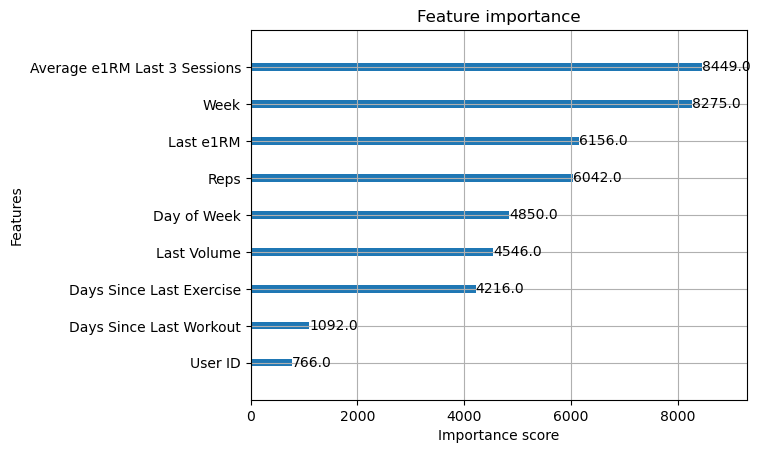

In [14]:
xgb.plot_importance(model, max_num_features=15)

Horrible Result. We will try implementing new features

In [7]:
session_df = (
    master_df.groupby(['User ID', 'Exercise Name', 'Date'])
    .agg({'e1RM': 'max', 'Weight': 'max'})  # or another aggregation
    .reset_index()
    .sort_values(['User ID', 'Exercise Name', 'Date'])
)

# 2. Get last session's e1RM and Weight
session_df['Last_Session_e1RM'] = (
    session_df.groupby(['User ID', 'Exercise Name'])['e1RM'].shift(1)
)
session_df['Last_Session_Weight'] = (
    session_df.groupby(['User ID', 'Exercise Name'])['Weight'].shift(1)
)

# 3. Merge back to the original dataframe
master_df = master_df.merge(
    session_df[['User ID', 'Exercise Name', 'Date', 'Last_Session_e1RM', 'Last_Session_Weight']],
    on=['User ID', 'Exercise Name', 'Date'],
    how='left'
)

master_df['Is_First_Session'] = master_df['Last_Session_Weight'].isna().astype(int)

In [8]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train[['User ID', 'Exercise Name']])

X_train_enc = enc.transform(X_train[['User ID', 'Exercise Name']]).toarray()
X_test_enc = enc.transform(X_test[['User ID', 'Exercise Name']]).toarray()

X_train_enc = np.concatenate([X_train_enc, X_train[['Reps', 'Day of Week', 'Week', 'Days Since Last Workout', 'Days Since Last Exercise', 'Average e1RM Last 3 Sessions']]], axis=1)
X_test_enc = np.concatenate([X_test_enc, X_test[['Reps', 'Day of Week', 'Week', 'Days Since Last Workout', 'Days Since Last Exercise', 'Average e1RM Last 3 Sessions']]], axis=1)

In [45]:
master_df

,User ID,Date,Exercise Name,Set Order,Weight,Reps,Volume,e1RM,Day of Week,Week,Days Since First Workout,Days Since Last Workout,Days Since Last Exercise,Average e1RM Last 3 Sessions,Last_Session_e1RM,Last_Session_Weight,Is_First_Session
0,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),1,135.00,8,1080.00,171.000000,4,43,0,NaN,NaN,NaN,NaN,NaN,1
1,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),2,135.00,8,1080.00,171.000000,4,43,0,0.0,0.0,171.000000,NaN,NaN,1
2,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),3,135.00,5,675.00,157.500000,4,43,0,0.0,0.0,171.000000,NaN,NaN,1
3,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),4,185.00,7,1295.00,228.166667,4,43,0,0.0,0.0,166.500000,NaN,NaN,1
4,0,2015-10-23 17:06:37,Incline Bench Press (Barbell),5,230.00,8,1840.00,291.333333,4,43,0,0.0,0.0,185.555556,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12243,1,2024-02-02 17:37:32,Lateral Raise (Dumbbell),4,18.00,3,54.00,19.800000,4,5,872,0.0,0.0,22.400000,22.8,18.00,0
12244,1,2024-02-02 17:37:32,Seated Row (Cable),1,41.25,12,495.00,57.750000,4,5,872,0.0,24.0,49.416667,55.0,41.25,0
12245,1,2024-02-02 17:37:32,Seated Row (Cable),2,41.25,8,330.00,52.250000,4,5,872,0.0,0.0,51.250000,55.0,41.25,0
12246,1,2024-02-02 17:37:32,Seated Row (Cable),3,41.25,5,206.25,48.125000,4,5,872,0.0,0.0,52.166667,55.0,41.25,0


Let's train and test again with these new features

In [9]:
# List of features to use
cat_features = ['User ID', 'Exercise Name']
num_features = [
    'Reps', 'Day of Week', 'Week', 'Days Since Last Workout', 'Days Since Last Exercise', 'Average e1RM Last 3 Sessions',
    'Last_Session_e1RM', 'Last_Session_Weight', 'Is_First_Session'
]

# Remove rows with NaN in any feature or target (optional, or you can impute)
train_df = train_df.dropna(subset=cat_features + num_features + ['Weight'])
test_df = test_df.dropna(subset=cat_features + num_features + ['Weight'])

In [10]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc.fit(train_df[cat_features])
feature_names = list(enc.get_feature_names_out(cat_features)) + num_features

X_train_cat = enc.transform(train_df[cat_features])
X_test_cat = enc.transform(test_df[cat_features])

X_train_num = train_df[num_features].values
X_test_num = test_df[num_features].values

X_train = np.concatenate([X_train_cat, X_train_num], axis=1)
X_test = np.concatenate([X_test_cat, X_test_num], axis=1)
y_train = train_df['Weight'].values
y_test = test_df['Weight'].values

In [11]:
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 24.76161456414988
RMSE: 41.10068775847131
R2: 0.8978578860807005


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

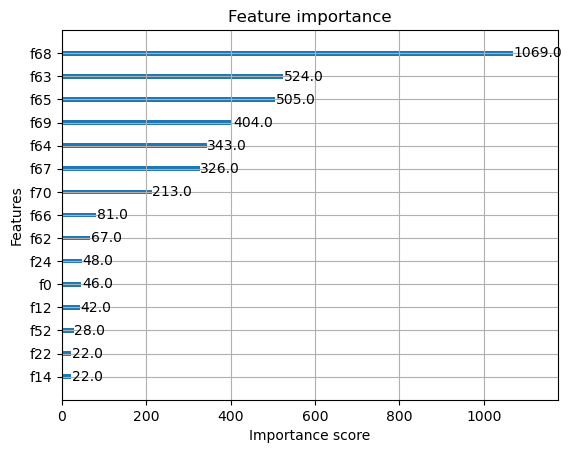

In [12]:
xgb.plot_importance(model, max_num_features=15)

In [13]:
# y_test: true weights, y_pred: predicted weights (as numpy arrays or pandas Series)
fig = px.scatter(
    x=y_test, y=y_pred,
    labels={'x': 'Actual Weight', 'y': 'Predicted Weight'},
    title='Predicted vs Actual Weight'
)

# Add y=x reference line (perfect prediction)
fig.add_shape(
    type='line',
    x0=min(y_test), y0=min(y_test),
    x1=max(y_test), y1=max(y_test),
    line=dict(color='red', dash='dash'),
    name='Perfect Prediction'
)

# Fit and plot regression line
slope, intercept = np.polyfit(y_test, y_pred, 1)
x_vals = np.array([min(y_test), max(y_test)])
y_vals = slope * x_vals + intercept
fig.add_traces([
    dict(
        type='scatter',
        x=x_vals,
        y=y_vals,
        mode='lines',
        line=dict(color='blue'),
        name='Regression Line'
    )
])

fig.show()

In [18]:
print("Min:", y_test.min())
print("Max:", y_test.max())
print("Mean:", y_test.mean())
print("Std:", y_test.std())

Min: 0.0
Max: 720.0
Mean: 152.17184252245906
Std: 128.60168778109295


In [66]:
mask = y_test != 0
mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
print(f"MAPE (excluding zeros): {mape:.2f}%")

MAPE (excluding zeros): 17.25%


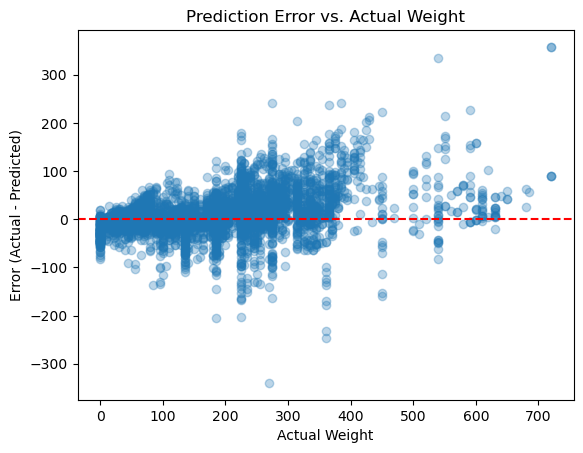

In [14]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_test - y_pred, alpha=0.3)
plt.xlabel("Actual Weight")
plt.ylabel("Error (Actual - Predicted)")
plt.title("Prediction Error vs. Actual Weight")
plt.axhline(0, color='red', linestyle='--')
plt.show()

Heteroscedasticity!

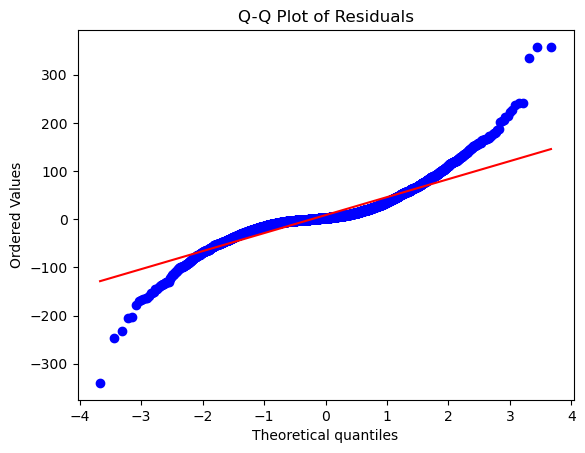

In [16]:
# Create Q-Q plot of residuals to check normality
import scipy.stats as stats

residuals = y_test - y_pred
fig = plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


Heavy Tailed, not normally distributed

In [18]:
# Add a small constant to avoid log(0)
epsilon = 1e-3
y_train_log = np.log1p(y_train + epsilon)

# Train on log-weight
model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log) - epsilon  # Back-transform

# Evaluate
mae = np.mean(np.abs(y_test - y_pred))
mask = y_test != 0  # Exclude zeros to avoid division by zero
mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
print(f"MAE: {mae:.2f}, MAPE (excluding zeros): {mape:.2f}%")

MAE: 24.87, MAPE (excluding zeros): 18.83%


In [ ]:
# Absolute errors for each exercise prediction
# Big lifts are off by a lot, isolation exercises are not off by much
test_df['abs_error'] = np.abs(y_test - y_pred)
print(test_df.groupby('Exercise Name')['abs_error'].mean().sort_values(ascending=False))

Exercise Name
Seated Leg Press (Machine)                 91.868195
Leg Press (Hinge)                          71.416626
Rack Pull - 1 Pin                          65.333435
Deadlift (Barbell)                         64.948615
Rack Pull 2 Pin                            63.221426
Deadlift - Trap Bar                        57.111440
Sling Shot Bench                           55.775053
Squat (Barbell)                            47.218107
Overhead Press (Barbell)                   44.551346
Shrugs                                     42.052798
Sling Shot Incline                         39.669125
Seated Shoulder Press (Barbell)            38.914119
Hammer Row Stand 1Armed                    38.574142
Close Grip Bench                           37.025273
Hammer High Row - 1 Arm                    35.914428
Front Squat (Barbell)                      35.262463
Hack Squat                                 35.015430
Hammer Seated Row (Close Grip)             34.920089
Weighted Dips                   

### Issues
We are seeing how the current model is being overwhelmed by the massive discrepancies in weights. There is clear geteroscedasticity present, where the model is very good at predicting lighter weights and gets progressively worse with larger errors when trying to predict heavier weights.

Lateral raises can be from 5-30 bounds on average, while squats and deadlifts are in the hundreds. Standardizing the weights by exercise won't help either, as to have an interpretable answer in the form of a weight we would need to revert any standardization transformation after the model's prediction, putting us back to square 1.

This now grants us the motivation to create a specialized model for each major lift. The model will only have to learn the specific progression for that movement.

## Multiple Models

In [8]:
#Final feature engineering -- relative weights

# Calculate the max e1RM for each user on each exercise
# Calculate max e1RM without renaming to avoid _x/_y suffixes
master_df['max_e1RM'] = master_df.groupby(['User ID', 'Exercise Name'])['e1RM'].transform('max')


# Create the new relative target variable
master_df['relative_intensity'] = master_df['Weight'] / master_df['max_e1RM']

# Create relative historical features
master_df['relative_last_weight'] = master_df['Last_Session_Weight'] / master_df['max_e1RM']
master_df['relative_last_e1RM'] = master_df['Last_Session_e1RM'] / master_df['max_e1RM']
master_df['relative_avg_e1RM'] = master_df['Average e1RM Last 3 Sessions'] / master_df['max_e1RM']

# Handle potential division by zero or missing maxes
master_df.fillna(0, inplace=True)

In [9]:
train_df = master_df.groupby('User ID').apply(lambda x: x[x['Days Since First Workout'] <= x['Days Since First Workout'].max() * 0.6]).reset_index(drop=True)
test_df = master_df.groupby('User ID').apply(lambda x: x[x['Days Since First Workout'] > x['Days Since First Workout'].max() * 0.6]).reset_index(drop=True)

/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_96176/541954687.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = master_df.groupby('User ID').apply(lambda x: x[x['Days Since First Workout'] <= x['Days Since First Workout'].max() * 0.6]).reset_index(drop=True)
/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_96176/541954687.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [15]:
from sklearn.model_selection import GridSearchCV

trained_models = {}
#  'Is_First_Session'
features = ['Reps', 'Days Since First Workout', 'Days Since Last Workout', 'Days Since Last Exercise', 'relative_last_weight', 'relative_last_e1RM', 'relative_avg_e1RM']

for exercise_name in train_df['Exercise Name'].unique():
    exercise_train_df = train_df[train_df['Exercise Name'] == exercise_name].copy()

    exercise_train_df.reset_index(drop=True, inplace=True)

    if len(exercise_train_df) < 10:
        continue

    X_train = exercise_train_df[features]
    y_train = exercise_train_df['relative_intensity']

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.05, 0.1]
    }

    # Use GridSearchCV to find the best model
    grid_search = GridSearchCV(
        estimator=xgb.XGBRegressor(objective='reg:squarederror'),
        param_grid=param_grid,
        cv=3, # 3-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    # The best model is now stored in grid_search.best_estimator_
    trained_models[exercise_name] = grid_search.best_estimator_
print(f"Successfully trained {len(trained_models)} models.")

Successfully trained 52 models.


In [18]:
all_predictions = []
all_actuals = []

for exercise_name in test_df['Exercise Name'].unique():
    # Skip if we don't have a trained model for this exercise
    if exercise_name not in trained_models:
        continue

    # 1. Filter the test data for the specific exercise
    exercise_test_df = test_df[test_df['Exercise Name'] == exercise_name].copy()
    exercise_test_df.reset_index(drop=True, inplace=True)

    if exercise_test_df.empty:
        continue

    # 2. **THE FIX**: Create X_test and y_test from the CORRECT filtered DataFrame
    # NOTE: 'User ID' and other global time features are removed as they are less relevant for specialized models
    X_test_filtered = exercise_test_df[features]
    y_test_filtered = exercise_test_df['relative_intensity']

    # 3. Load the correct, specialized model
    model = trained_models[exercise_name]

    # 4. Predict using the CORRECT filtered data
    y_pred = model.predict(X_test_filtered)

    # 5. Evaluate using the CORRECT filtered data
    print(f"""{exercise_name}
    ==========================
    MAE: {mean_absolute_error(y_test_filtered, y_pred):.2f}
    R2: {r2_score(y_test_filtered, y_pred):.2f}\n""")

    # Append results for overall score calculation
    all_predictions.extend(y_pred)
    all_actuals.extend(y_test_filtered)

# --- Overall Performance ---
print(f"""\n\n--- Overall Model Performance ---
================================
Overall MAE: {mean_absolute_error(all_actuals, all_predictions):.2f}
Overall R2: {r2_score(all_actuals, all_predictions):.2f}""")

Incline Bench Press (Barbell)
    MAE: 0.11
    R2: -0.36

Shoulder Press (Standing)
    MAE: 0.13
    R2: -1.00

Weighted Dips
    MAE: 0.08
    R2: 0.25

Lateral Raise (Dumbbell)
    MAE: 0.11
    R2: -0.30

Chin Up
    MAE: 0.19
    R2: 0.04

Bent Over Row (Dumbbell)
    MAE: 0.14
    R2: -0.32

Pull Up
    MAE: 0.26
    R2: -9.63

Hammer Curl (Dumbbell)
    MAE: 0.09
    R2: -0.14

Squat (Barbell)
    MAE: 0.11
    R2: 0.11

Leg Outward Fly
    MAE: 0.09
    R2: -1.50

Seated Leg Curl (Machine)
    MAE: 0.06
    R2: -1.45

Deadlift (Barbell)
    MAE: 0.13
    R2: -0.31

Seated Shoulder Press (Barbell)
    MAE: 0.10
    R2: 0.08

Bicep Curl (Barbell)
    MAE: 0.08
    R2: 0.00

Hammer Seated Row (Close Grip)
    MAE: 0.05
    R2: 0.11

Incline Bench Press (Dumbbell)
    MAE: 0.04
    R2: 0.17

Leg Press (Hinge)
    MAE: 0.12
    R2: -0.78

Seated Cable Row (Close Grip)
    MAE: 0.07
    R2: 0.02

Rear Delt Fly
    MAE: 0.04
    R2: -0.29

Bench Press (Barbell)
    MAE: 0.16
    R2: 

In [21]:
master_df[master_df['Exercise Name'] == 'Squat (Barbell)'].groupby('User ID')['Weight'].describe()

,count,mean,std,min,25%,50%,75%,max
User ID,,,,,,,,
0,1394.0,280.817791,65.365600,95.0,225.0,280.0,335.0,425.0
1,84.0,48.095238,9.213164,30.0,40.0,50.0,55.0,80.0


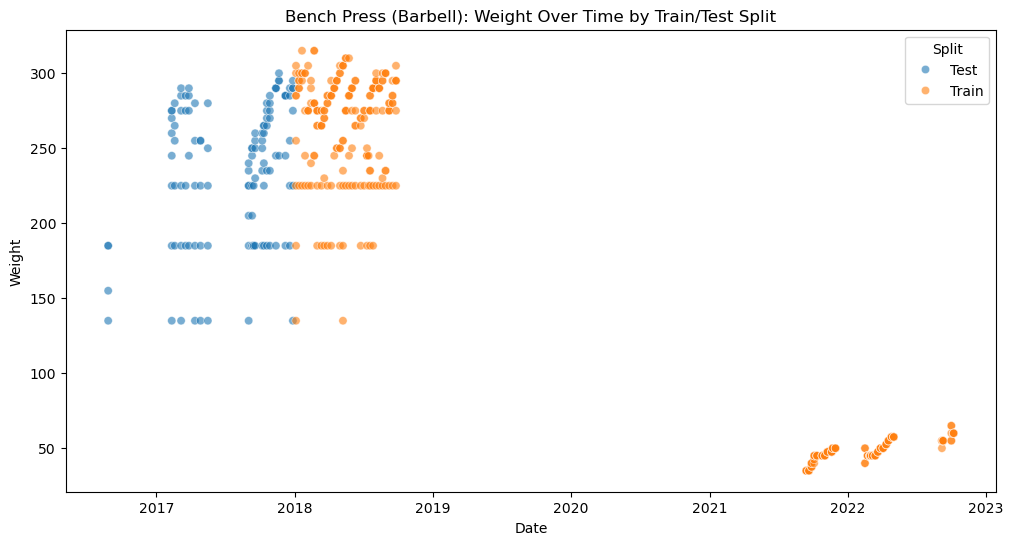

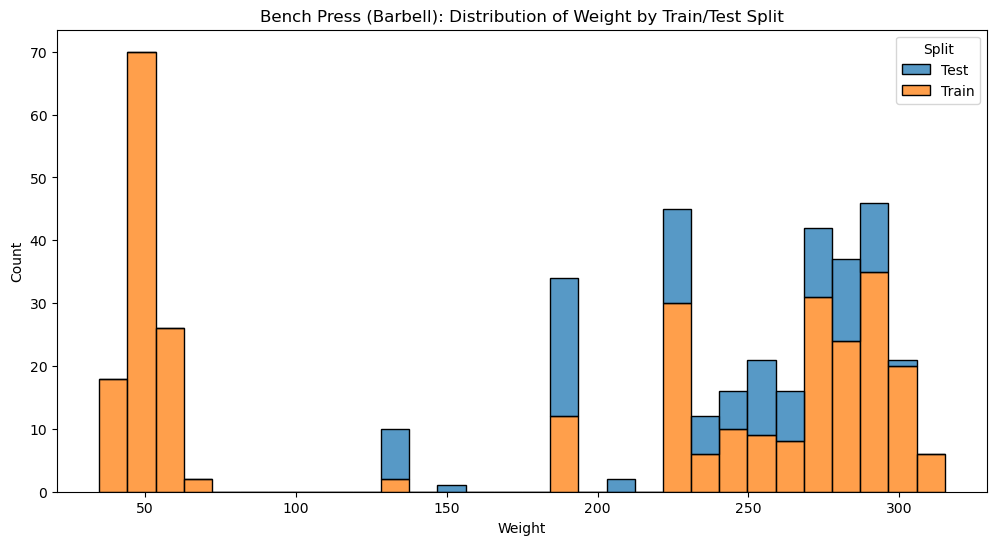

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Isolate the data for one exercise
exercise_to_analyze = 'Bench Press (Barbell)'
df_bench = master_df[master_df['Exercise Name'] == exercise_to_analyze].copy()

# Add a column to identify which split each row belongs to
df_bench['Split'] = 'Train'
df_bench.loc[df_bench.index.isin(test_df.index), 'Split'] = 'Test'


# --- PLOT 1: Performance Over Time ---
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_bench, x='Date', y='Weight', hue='Split', alpha=0.6)
plt.title(f'{exercise_to_analyze}: Weight Over Time by Train/Test Split')
plt.show()


# --- PLOT 2: Weight Distributions ---
plt.figure(figsize=(12, 6))
sns.histplot(data=df_bench, x='Weight', hue='Split', multiple='stack', bins=30)
plt.title(f'{exercise_to_analyze}: Distribution of Weight by Train/Test Split')
plt.show()

In [29]:
master_df.groupby('User ID')['Date'].min(), master_df.groupby('User ID')['Date'].max()

(User ID
 0   2015-10-23 17:06:37
 1   2021-09-13 10:41:41
 Name: Date, dtype: datetime64[ns],
 User ID
 0   2018-09-29 14:35:32
 1   2024-02-02 17:37:32
 Name: Date, dtype: datetime64[ns])